In [3]:
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv("../data/fulldata.csv")
df2 = pd.read_csv("../data/6_14_pull.csv")

df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,1.646272e+09
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,1.646271e+09
2,State of the union,Liberal,1,t5fj9a,DemocraticSocialism,https://www.reddit.com/r/DemocraticSocialism/c...,1,Who watched the state of the union last night ...,1.646270e+09
3,We Should Just Give Poor People Money,Liberal,7,t5f7n9,SocialDemocracy,https://youtu.be/a80kRjpubG0,3,NaN,1.646270e+09
4,Do it for the Dew,Liberal,6,t5es2c,democrats,https://i.redd.it/drmunn90f2l81.jpg,1,NaN,1.646268e+09
...,...,...,...,...,...,...,...,...,...
12849,Ron Paul’s Spirited Defense of WikiLeaks & Fre...,Conservative,2,em7rm,anarchocapitalism,http://www.deathandtaxesmag.com/40485/ron-paul...,1,NaN,1.292421e+09
12850,"“Anarcho-capitalism, in my opinion, is a doctr...",Conservative,2,ei98o,anarchocapitalism,http://www.pressaction.com/news/weblog/full_ar...,1,NaN,1.291813e+09
12851,Mises Wiki is a wiki project dedicated to the ...,Conservative,2,e6x22,anarchocapitalism,http://wiki.mises.org/wiki/Main_Page,0,NaN,1.289910e+09
12852,Fireman Protection Monopoly - Is This Failed C...,Conservative,2,e4vtd,anarchocapitalism,http://www.csmonitor.com/Business/Mises-Econom...,0,NaN,1.289524e+09


In [5]:
pd.concat([df,df2])

,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,1.646272e+09
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,1.646271e+09
2,State of the union,Liberal,1,t5fj9a,DemocraticSocialism,https://www.reddit.com/r/DemocraticSocialism/c...,1,Who watched the state of the union last night ...,1.646270e+09
3,We Should Just Give Poor People Money,Liberal,7,t5f7n9,SocialDemocracy,https://youtu.be/a80kRjpubG0,3,NaN,1.646270e+09
4,Do it for the Dew,Liberal,6,t5es2c,democrats,https://i.redd.it/drmunn90f2l81.jpg,1,NaN,1.646268e+09
...,...,...,...,...,...,...,...,...,...
10320,FBI gets an ‘F’ in trust due to recent scandal...,Conservative,73,NaN,NaN,NaN,8,NaN,NaN
10321,Why Kari Lake Couldn't Close the Deal - Ballot...,Conservative,2,NaN,NaN,NaN,1,NaN,NaN
10322,Capitol rioter who put foot on Nancy Pelosi's ...,Conservative,8,NaN,NaN,NaN,1,NaN,NaN
10323,Karine Jean-Pierre Showered With Receipts Afte...,Conservative,39,NaN,NaN,NaN,2,NaN,NaN


In [2]:
from Cleaning import lowercase, unpunctuate, tokenize, lemmatize, count_capitalized_words, create_other_var, cleaning_and_prep, stack_vectors

In [3]:
X_train, X_test, y_train, y_test = cleaning_and_prep(df)

C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Conservative',0)


In [4]:
X_train_vec, X_test_vec, X_train, X_test = stack_vectors(X_train,X_test)

Epoch 1/100
441/441 [==============================] - 14s 22ms/step - loss: 0.6498 - accuracy: 0.6020 - auc: 0.6545 - val_loss: 0.6047 - val_accuracy: 0.6715 - val_auc: 0.7581
Epoch 2/100
441/441 [==============================] - 9s 20ms/step - loss: 0.6062 - accuracy: 0.6560 - auc: 0.7302 - val_loss: 0.5785 - val_accuracy: 0.6844 - val_auc: 0.7736
Epoch 3/100
441/441 [==============================] - 9s 21ms/step - loss: 0.5879 - accuracy: 0.6742 - auc: 0.7524 - val_loss: 0.5579 - val_accuracy: 0.7097 - val_auc: 0.7889
Epoch 4/100
441/441 [==============================] - 9s 20ms/step - loss: 0.5758 - accuracy: 0.6827 - auc: 0.7599 - val_loss: 0.5484 - val_accuracy: 0.7105 - val_auc: 0.8020
Epoch 5/100
441/441 [==============================] - 9s 21ms/step - loss: 0.5703 - accuracy: 0.6879 - auc: 0.7684 - val_loss: 0.5466 - val_accuracy: 0.7045 - val_auc: 0.8017
Epoch 6/100
441/441 [==============================] - 9s 20ms/step - loss: 0.5656 - accuracy: 0.6885 - auc: 0.7706 - v

<Axes: >

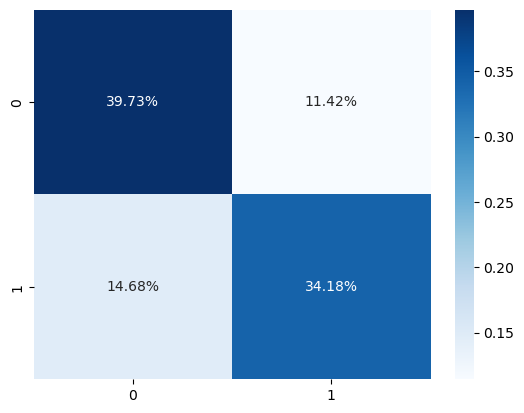

In [5]:
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score

# First branch for the LSTM
lstm_input = Input(shape=(1, 100))
lstm_output = LSTM(units=256, return_sequences=True, activation='relu')(lstm_input)
lstm_output = Dropout(0.2)(lstm_output)
lstm_output = LSTM(units=256, return_sequences=True, activation='relu')(lstm_output)
lstm_output = Dropout(0.2)(lstm_output)
lstm_output = LSTM(units=128, return_sequences=True, activation='relu')(lstm_output)
lstm_output = Dropout(0.2)(lstm_output)
lstm_output = LSTM(units=64, activation='relu')(lstm_output)
lstm_output = Dropout(0.2)(lstm_output)

# Second branch for the dense layers
dense_input = Input(shape=(5,))
dense_output = Dense(units=64, activation='relu')(dense_input)
dense_output = Dropout(0.2)(dense_output)
dense_output = Dense(units=32, activation='relu')(dense_output)
dense_output = Dropout(0.2)(dense_output)

# Concatenate the outputs from both branches
combined = concatenate([lstm_output, dense_output])

combined = Dense(units = 64, activation='relu')(combined)

# Final output layer
output = Dense(units=1, activation='sigmoid')(combined)

# Create the model
model = Model(inputs=[lstm_input, dense_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with both LSTM and dense input
model.fit([X_train_vec, X_train], y_train, epochs=100, batch_size=32,
          validation_data=([X_test_vec, X_test], y_test),
          callbacks=[early_stopping])

# Predict and evaluate
y_pred = model.predict([X_test_vec, X_test])
roc_auc = roc_auc_score(y_test, y_pred)

y_pred_class = (y_pred > .5).astype(int)
accuracy = accuracy_score(y_test,y_pred_class)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred_class)

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

In [6]:
#model containing character length, number of capital words, upvotes and # of comments
#Model 2 adds POS tagging and standard scaling of variables
#Only left in proper nouns as others decreased performance

In [7]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

#create extra variables for later
df_other_var = create_other_var(df)

#Create simple dataframe with only text and predictor
df = df[['Title','Political Lean']] 

#dummy code predictor
df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
df['Political Lean'] = df['Political Lean'].replace('Conservative',0)

df = df.rename({'Political Lean':'y'},axis=1) #replace column name for simplicity

df = pd.concat([df,df_other_var],axis=1)

df = df[df['Length']>=15]

#Split into X & y
X = df.drop(['y'],axis=1)
y = df['y']

#oversample minority class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13)
X, y = oversample.fit_resample(X, y)

In [8]:
loss_df = X_test.merge(X[['Title']],left_index=True,right_index=True,how='left')
loss_df = loss_df.merge(y,left_index=True,right_index=True,how='left')
predictions = pd.DataFrame(y_pred, columns = ['prob'])
loss_df = pd.concat([loss_df,predictions.set_index(loss_df.index)],axis=1)
loss_df['prob'] = abs(loss_df['prob']-.5)

AttributeError: 'numpy.ndarray' object has no attribute 'merge'

In [ ]:
loss_df.sort_values(by='prob').head(50)